# 1. Try different values of the max_examples argument in the _tokenize method. How does this affect the vocabulary sizes of the source language and the target language?

In [3]:
import sys
import torch.nn as nn
import torch
import warnings
from sklearn.model_selection import ParameterGrid
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")

class MTFraEng(d2l.DataModule):  #@save
    """The English-French dataset."""
    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()
        
    def _preprocess(self, text):
        # Replace non-breaking space with space
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        # Insert space between words and punctuation marks
        no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
        out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
               for i, char in enumerate(text.lower())]
        return ''.join(out)
    
    def _tokenize(self, text, max_examples=None):
        src, tgt = [], []
        for i, line in enumerate(text.split('\n')):
            if max_examples and i > max_examples: break
            parts = line.split('\t')
            if len(parts) == 2:
                # Skip empty tokens
                src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
                tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
        return src, tgt
    
    def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
        super(MTFraEng, self).__init__()
        self.save_hyperparameters()
        self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
            self._download())

    def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
        def _build_array(sentences, vocab, is_tgt=False):
            pad_or_trim = lambda seq, t: (
                seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
            sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
            if is_tgt:
                sentences = [['<bos>'] + s for s in sentences]
            if vocab is None:
                vocab = d2l.Vocab(sentences, min_freq=2)
            array = torch.tensor([vocab[s] for s in sentences])
            valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
            return array, vocab, valid_len
        src, tgt = self._tokenize(self._preprocess(raw_text),
                                  self.num_train + self.num_val)
        src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
        return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
                src_vocab, tgt_vocab)
    
    def get_dataloader(self, train):
        """Defined in :numref:`subsec_loading-seq-fixed-len`"""
        idx = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader(self.arrays, train, idx)

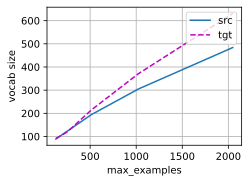

In [14]:
num_trains = d2l.gen_logrithm_nums(initial_value = 128, growth_factor = 2, num_elements = 5)
src_lens, tgt_lens = [], []
for num_train in num_trains:
    data = MTFraEng(batch_size=3, num_train=num_train)
    src_lens.append(len(data.src_vocab))
    tgt_lens.append(len(data.tgt_vocab))
d2l.plot(num_trains, [src_lens,tgt_lens],'max_examples','vocab size', legend=['src','tgt'])

# 2. Text in some languages such as Chinese and Japanese does not have word boundary indicators (e.g., space). Is word-level tokenization still a good idea for such cases? Why or why not?

Word-level tokenization is still a good idea for languages such as Chinese and Japanese, even though they do not have word boundary indicators. There are several reasons for this:

- Word-level tokenization can help to reduce the ambiguity and complexity of natural language processing tasks, such as name tagging, part-of-speech tagging, syntactic parsing, semantic analysis, machine translation, information retrieval, and text summarization. By identifying the word boundaries, the tokenization process can provide more meaningful and informative units for the downstream tasks, and reduce the search space and computational cost of the algorithms³.
- Word-level tokenization can also help to capture the linguistic and semantic properties of words, such as morphology, syntax, and semantics. For example, Chinese words can have different meanings and functions depending on their positions and contexts in a sentence. By segmenting the words correctly, the tokenization process can preserve the internal structure and external relations of words, and facilitate the understanding and generation of natural language².
- Word-level tokenization can also help to improve the performance and accuracy of natural language processing systems, especially for dealing with unknown or out-of-vocabulary words. Unknown words are words that do not exist in a system's dictionary or training data, and they pose a great challenge for word segmentation. By using both word-level and character-level information, such as statistical models, neural networks, or hybrid methods, the tokenization process can effectively handle known and unknown words, and achieve high overall accuracy¹².

Therefore, word-level tokenization is still a good idea for languages such as Chinese and Japanese, even though they do not have word boundary indicators. It is an essential and beneficial step for many natural language processing applications.


- (1) Comparison of the Impact of Word Segmentation on Name .... http://www.lrec-conf.org/proceedings/lrec2014/pdf/358_Paper.pdf.
- (2) Chinese and Japanese Word Segmentation Using Word-Level .... https://aclanthology.org/C04-1067.pdf.
- (3) Word Segmentation Standard in Chinese, Japanese and Korean. https://aclanthology.org/W09-3426.pdf.
- (4) The Challenges of Chinese and Japanese Searching - hybrismart. https://hybrismart.com/2019/08/18/the-challenges-of-chinese-and-japanese-searching/.